In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords

import spacy
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV, cross_val_score

import scipy

source of data is https://www.kaggle.com/crowdflower/twitter-airline-sentiment

there was no description of features

In [3]:
data = pd.read_csv('data/Tweets.csv')

In [4]:
print('N of tweets with the same text', len(data['text']) - len(data['text'].drop_duplicates()))

N of tweets with the same text 213


In [5]:
data = data.drop_duplicates('text')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14427 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14427 non-null int64
airline_sentiment               14427 non-null object
airline_sentiment_confidence    14427 non-null float64
negativereason                  9080 non-null object
negativereason_confidence       10410 non-null float64
airline                         14427 non-null object
airline_sentiment_gold          40 non-null object
name                            14427 non-null object
negativereason_gold             32 non-null object
retweet_count                   14427 non-null int64
text                            14427 non-null object
tweet_coord                     1003 non-null object
tweet_created                   14427 non-null object
tweet_location                  9760 non-null object
user_timezone                   9677 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.8+ MB


In [7]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# EDA

Target class distibution

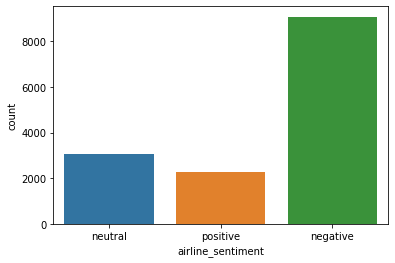

In [8]:
sns.countplot(x='airline_sentiment', data=data);

Some airlines have more ratio of negative tweets than others

In [9]:
data['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

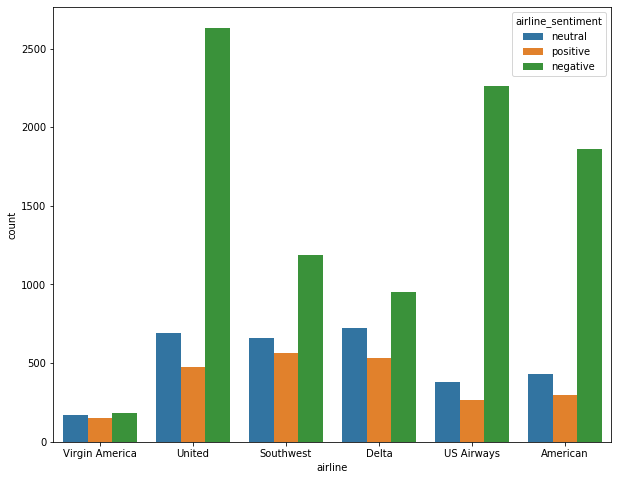

In [10]:
fig, ax = plt.subplots(figsize=(10, 8));
sns.countplot(x='airline', hue='airline_sentiment', data=data, ax=ax);

Distribution of contributers confidence. I suppose that this number is highly subjective.

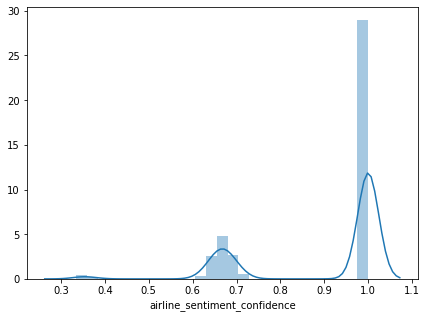

In [11]:
_, ax = plt.subplots(figsize=(7, 5));
sns.distplot(data['airline_sentiment_confidence'], ax=ax);

In [12]:
data['negativereason'].unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [13]:
'Partition of nan {}'.format(len(data[data['negativereason'].isna()]) / len(data))

'Partition of nan 0.3706245234629514'

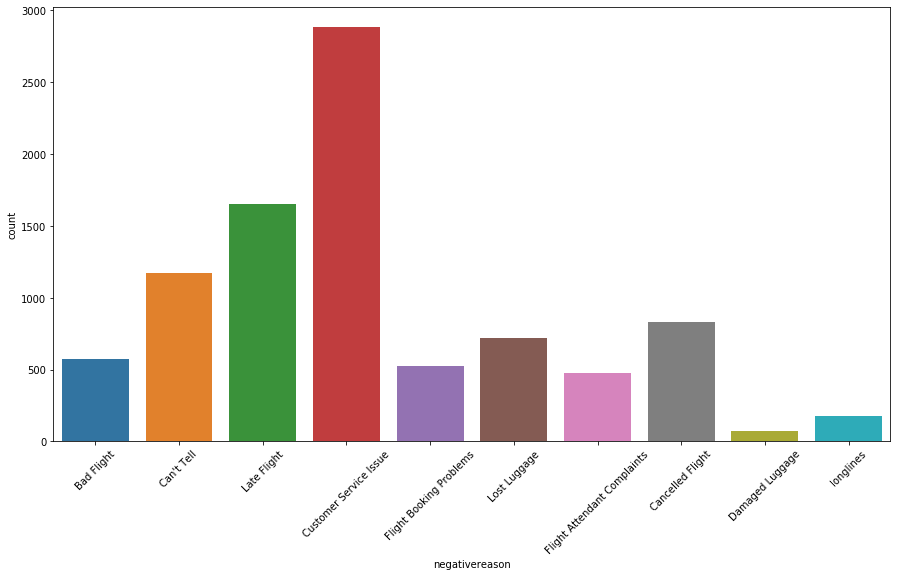

In [40]:
fig, ax = plt.subplots(figsize=(15, 8));
plot = sns.countplot(x='negativereason', data=data, ax=ax)
plt.setp(plot.get_xticklabels(), rotation=45);

Again some strange feature

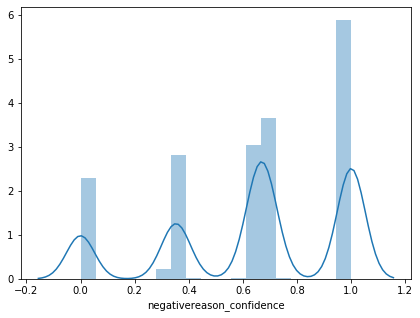

In [41]:
_, ax = plt.subplots(figsize=(7, 5));
sns.distplot(data['negativereason_confidence'].dropna(), ax=ax);

In this project I will be using only text data for sentiment analysis

In [42]:
en_stopwords = stopwords.words('english')

Most popular words

In [43]:
# each text has @nameofcompany as the first word
# I will delete these first words as they are stopwords now
texts = [text.split(' ')[1:] for text in data['text'].tolist()]
texts = ' '.join([' '.join(text) for text in texts])

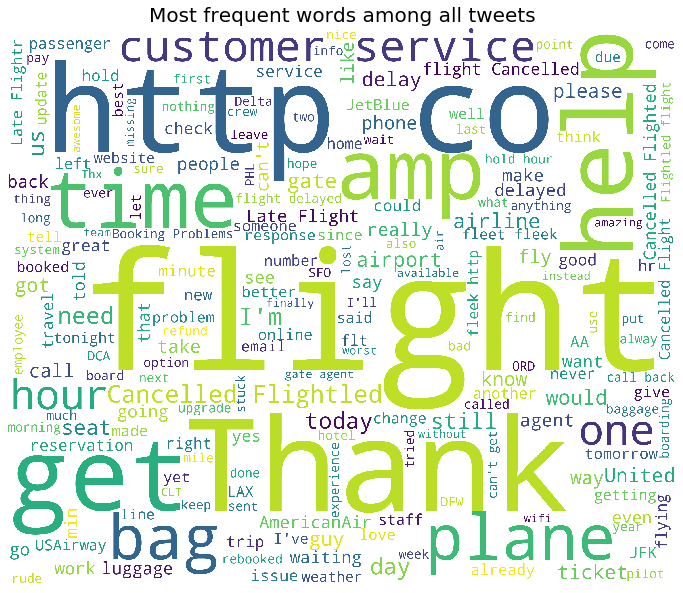

In [44]:
wordcloud = WordCloud(stopwords=en_stopwords,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(texts)
plt.figure(1,figsize=(12, 12))
plt.title('Most frequent words among all tweets', fontsize=20)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We see that tweets contain lots of https. The most frequent words are about planes (wow), thankings, help, time

Most popular words in each class

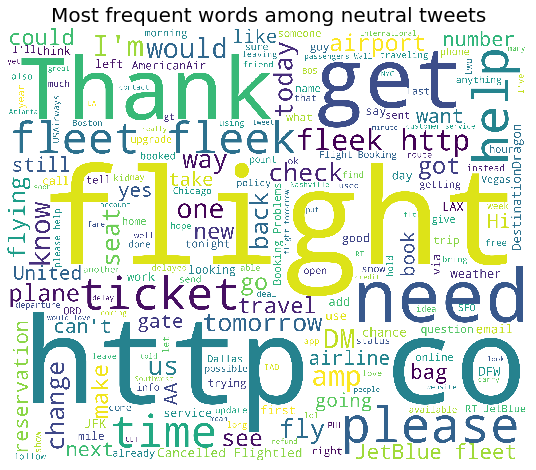

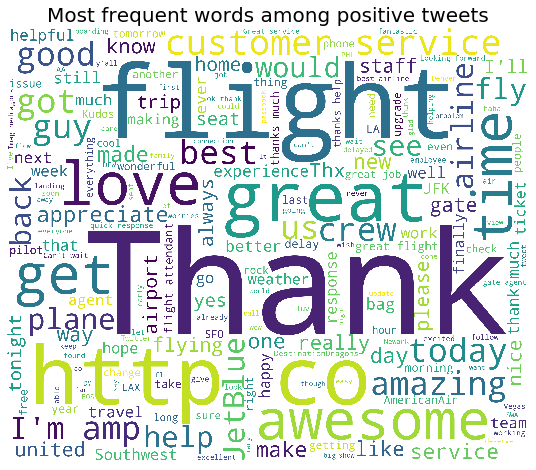

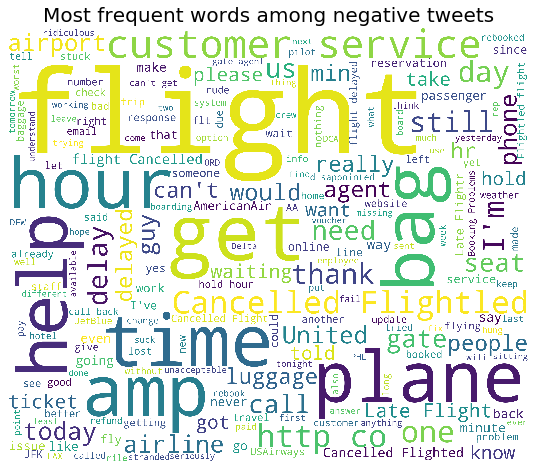

In [45]:
for label in data['airline_sentiment'].unique():
    texts = [text.split(' ')[1:] for text in data[data['airline_sentiment'] == label]['text'].tolist()]
    texts = ' '.join([' '.join(text) for text in texts])
    wordcloud = WordCloud(stopwords=en_stopwords,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(texts)
    plt.figure(1,figsize=(10, 8))
    plt.title(f'Most frequent words among {label} tweets', fontsize=20)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Its interesting that the word 'thank' is pretty frequent in neutral tweets.

Average tweet length

Min tweet len 2, max tweet len 36


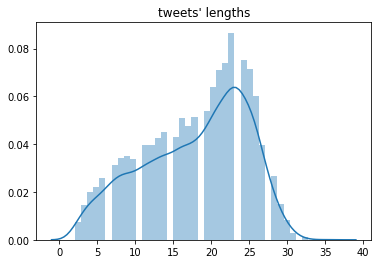

In [46]:
lens = [len(text.split(' ')) for text in data['text']]
print(f'Min tweet len {min(lens)}, max tweet len {max(lens)}')
sns.distplot(lens).set_title("tweets' lengths");

We see that tweets are pretty short

Average length per label

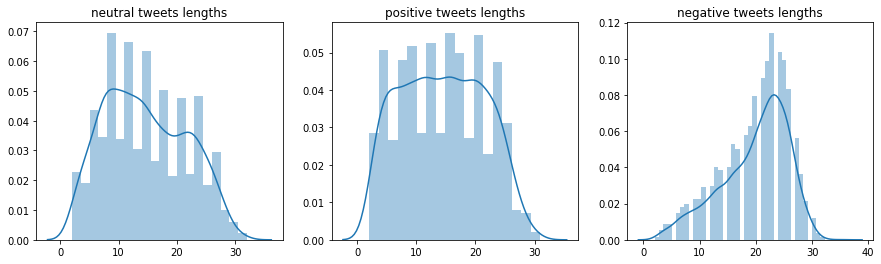

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
for i, label in enumerate(data['airline_sentiment'].unique()):
    lens = [len(text.split(' ')) for text in data[data['airline_sentiment'] == label]['text']]
    sns.distplot(lens, ax=ax[i]).set_title(f'{label} tweets lengths');
plt.show()

Here we see that negative tweets tend to be longer the positive of neutral

# Baseline

As a baseline I will try SVM over TF-IDF vectors as often gives strong results in text classification

In [14]:
nlp = spacy.load('en_core_web_sm')
def process_text(text):
    """
    replace http link with <link> token
    tokenize with spacy
    first token will be thrown as model can become biased because of disbalances
        in class destribution through companies
    """
    sp = nlp(text)
    tokens = [tok.text if 'http' not in tok.text else '<link>' for tok in sp]
    return ' '.join(tokens[1:])

In [15]:
data['procesed_text'] = data['text'].apply(lambda x: process_text(x))

In [16]:
data['procesed_text'].head(10)

0                                What @dhepburn said .
1    plus you 've added commercials to the experien...
2    I did n't today ... Must mean I need to take a...
3    it 's really aggressive to blast obnoxious " e...
4            and it 's a really big bad thing about it
5    seriously would pay $ 30 a flight for seats th...
6    yes , nearly every time I fly VX this “ ear wo...
7    Really missed a prime opportunity for Men With...
8                 Well , I didn't … but NOW I DO ! :-D
9    it was amazing , and arrived an hour early . Y...
Name: procesed_text, dtype: object

In [17]:
label_dic = {'negative': -1, 'neutral': 0, 'positive': 1}
data['label'] = data['airline_sentiment'].apply(lambda x: label_dic[x])

In [82]:
train, test = train_test_split(data, test_size=0.2, stratify=data[['airline_sentiment', 'airline']],
                               random_state=21)

In [83]:
x_train, y_train = train['procesed_text'].tolist(), train['label'].tolist()
x_test, y_test = test['procesed_text'].tolist(), test['label'].tolist()

In [84]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [85]:
x_train_tfidf = Tfidf_vect.transform(x_train)
x_test_tfidf = Tfidf_vect.transform(x_test)

In [88]:
params = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf', 'linear'], 'class_weight':['balanced', None]}

In [97]:
clf = RandomizedSearchCV(svm.SVC(), params, cv=5,
                       scoring='f1_macro', n_jobs=-1, n_iter=50, verbose=2)
clf.fit(x_train_tfidf, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d07e34240>,
                                        'class_weight': ['balanced', None],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d07e1d1d0>,
                                        'kernel': ['rbf', 'linear']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
     

In [102]:
clf.best_params_

{'C': 20.732554555336343,
 'class_weight': None,
 'gamma': 0.02763390783963825,
 'kernel': 'rbf'}

In [103]:
preds = clf.predict(x_test_tfidf)

In [106]:
accuracy_score(preds, y_test)

0.7986832986832987

In [107]:
f1_score(preds, y_test, average='macro'), f1_score(preds, y_test, average='micro')

(0.7270594492415711, 0.7986832986832987)

So baseline for the task is about 0.72 for macro f1_score, 0.8 for micro f1_score